In [37]:
!pip install tensorflow scikeras
!pip install skorch torch

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
    --------------------------------------- 3.9/204.1 MB 20.3 MB/s eta 0:00:10
   - -------------------------------------- 8.4/204.1 MB 20.8 MB/s eta 0:00:10
   -- ------------------------------------- 12.8/204.1 MB 21.0 MB/s eta 0:00:10
   --- ------------------------------------ 16.3/204.1 MB 19.6 MB/s eta 0:00:10
   ---- ----------------------------------- 21.0/204.1 MB 20.1 MB/s eta 0:00:10
   ----- ---------------------------------- 25.7/204.1 MB 20.5 MB/s eta 0:00:09
   ------ --------------------------------- 30.7/204.1 MB 20.9 MB/s eta 0:00:09
   ------ --------------------------------- 34.6/204.1 MB 20.7 MB/s eta 0:00:09
   ------- -------------------------------- 39.3/204.1 MB 21.0 MB/s eta 0:00:08
   -------- ------------------------------- 43.5/204.1 MB 20.9 MB/s eta 0:00:08
   --------- ------------------------------ 48.5/204.1 MB 21.1 MB/s et

In [20]:
from cuml.svm import SVC
svc_gpu = SVC(probability=True)  # Uses GPU


ModuleNotFoundError: No module named 'cuml'

In [1]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow Version: 2.12.0
Num GPUs Available: 0


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from scipy.stats import zscore

# Sklearn imports for scaling, splitting, modeling, evaluation, and hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Additional libraries for boosting models
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier

In [2]:
# Example: Download data using yfinance library (install it if needed: pip install yfinance)
import yfinance as yf

# Define the ticker symbol (e.g., "AAPL" for Apple Inc.)
ticker = "AAPL"

# Download historical data (last 5 years)
data = yf.download(ticker, period="5y", interval="1d")

# Save the data to a CSV file for later use
data.to_csv("data/stock_data.csv")

# Display the first few rows
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-03-04,73.468643,73.628812,71.136501,71.939768,219178400
2020-03-05,71.085541,72.694496,70.719093,71.716500,187572800
2020-03-06,70.141502,70.575900,68.248609,68.435470,226176800
2020-03-09,64.593880,67.486610,63.824584,64.006593,286744800
2020-03-10,69.246040,69.512989,65.370456,67.256077,285290000


In [3]:
df = pd.read_csv(
    "data/stock_data.csv",
    skiprows=3,                # Skip the first two lines
    names=["Date", "Close", "High", "Low", "Open", "Volume"]
)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
print(df.head())
print("\nData Description:")
print(df.describe())


                Close       High        Low       Open     Volume
Date                                                             
2020-03-04  73.468643  73.628812  71.136501  71.939768  219178400
2020-03-05  71.085541  72.694496  70.719093  71.716500  187572800
2020-03-06  70.141502  70.575900  68.248609  68.435470  226176800
2020-03-09  64.593880  67.486610  63.824584  64.006593  286744800
2020-03-10  69.246040  69.512989  65.370456  67.256077  285290000

Data Description:
             Close         High          Low         Open        Volume
count  1256.000000  1256.000000  1256.000000  1256.000000  1.256000e+03
mean    157.429534   159.017698   155.661333   157.275016  8.713112e+07
std      42.130022    42.291977    41.878114    42.070131  5.051607e+07
min      54.449894    55.452160    51.595990    55.350235  2.323470e+07
25%     130.590221   131.919729   128.955901   130.634586  5.392302e+07
50%     154.884697   156.823957   152.105361   154.564538  7.408865e+07
75%     181.581

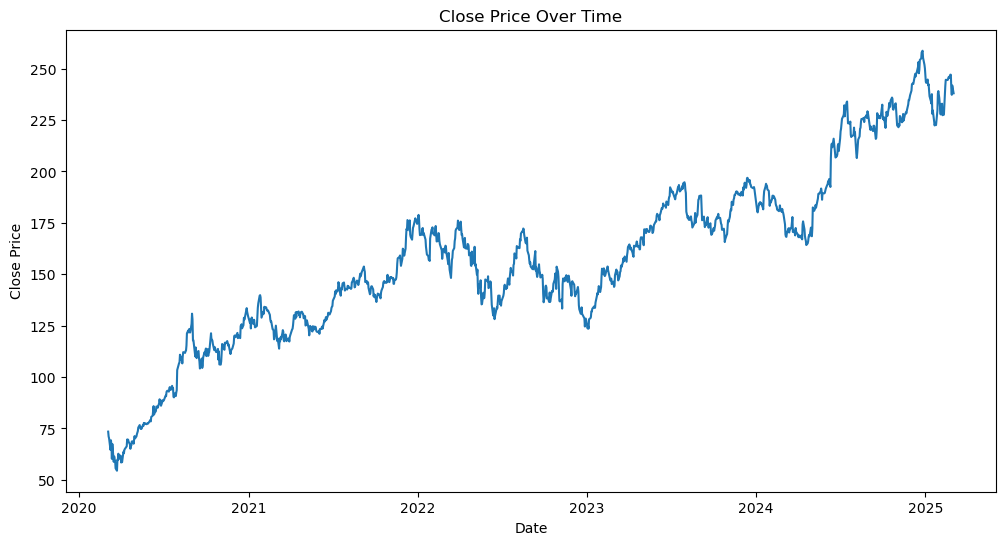

In [4]:
# Plot the Close price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

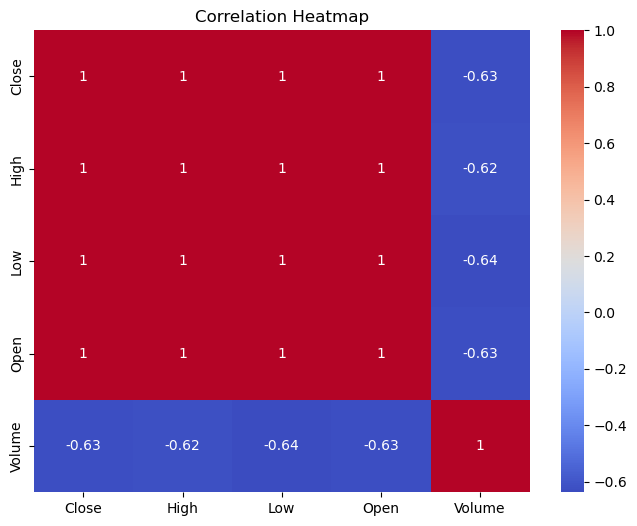

In [5]:
# Plot correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [6]:
# ---------------------------
# Outlier Detection & Handling
# ---------------------------
# Remove outliers from the 'Close' column using a z-score threshold (|z| < 3)
df['Close_z'] = zscore(df['Close'])
df = df[df['Close_z'].abs() < 3]
df.drop(columns=['Close_z'], inplace=True)

In [7]:
# ---------------------------
# Feature Engineering
# ---------------------------
# Create Technical Indicators using ta (instead of pandas_ta)

# 1. Simple Moving Average (SMA) for a 20-day period
df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

# 2. Exponential Moving Average (EMA) for a 20-day period
df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

# 3. Relative Strength Index (RSI) with a 14-day period
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 4. Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df['MACD_Hist'] = macd.macd_diff()

# Drop initial rows with NaNs after indicator calculations
df.dropna(inplace=True)

# Generate "Returns" Feature: daily percentage change in 'Close'
df['Return'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Define the binary Target: 1 if next day's Close > today's, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df.dropna(inplace=True)

print(df.head())

                Close       High        Low       Open     Volume      SMA20  \
Date                                                                           
2020-04-22  67.003670  67.440489  66.057223  66.399394  116862400  64.062774   
2020-04-23  66.744026  68.374830  66.705197  66.947876  124814400  64.420848   
2020-04-24  68.670883  68.680592  67.222089  67.270628  126161200  64.718493   
2020-04-27  68.719421  69.051890  67.937995  68.386945  117087600  65.148400   
2020-04-28  67.605515  69.364937  67.513303  69.182928  112004800  65.436823   

                EMA20        RSI      MACD  MACD_Signal  MACD_Hist    Return  \
Date                                                                           
2020-04-22  65.404447  53.541241  0.788498     0.285354   0.503144  0.028804   
2020-04-23  65.532026  52.949006  0.778924     0.384068   0.394856 -0.003875   
2020-04-24  65.830965  56.770576  0.916256     0.490506   0.425750  0.028869   
2020-04-27  66.106056  56.865618  1.017

In [8]:
# ---------------------------
# Data Scaling
# ---------------------------
# Define feature columns; adjust as needed
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA20', 'EMA20', 'RSI', 
            'MACD', 'MACD_Signal', 'MACD_Hist', 'Return']
X = df[features]
y = df['Target']

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

In [9]:
# ---------------------------
# Train/Test Split: Chronological
# ---------------------------
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled.iloc[:train_size]
X_test  = X_scaled.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("Training set size:", X_train.shape, " Testing set size:", X_test.shape)

Training set size: (977, 12)  Testing set size: (245, 12)


In [10]:
# Create and train the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.39591836734693875
Confusion Matrix:
 [[ 82  19]
 [129  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.81      0.53       101
           1       0.44      0.10      0.17       144

    accuracy                           0.40       245
   macro avg       0.41      0.46      0.35       245
weighted avg       0.42      0.40      0.32       245



In [28]:
import xgboost as xgb
import lightgbm as lgb
# ---------------------------
# Define Models Dictionary and Parameter Distributions for Tuning
# ---------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVC": SVC(probability=True),
    "KNN Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=5000),
    "AdaBoost": AdaBoostClassifier(),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "XGBoost (GPU)": xgb.XGBClassifier(eval_metric='logloss', device='cuda', random_state=42),

    "LightGBM (GPU)": lgb.LGBMClassifier(device='gpu', random_state=42)  # GPU Enabled
}

# Use wider search spaces and logarithmically spaced values where appropriate.
param_distributions = {
    "Logistic Regression": {
        'C': np.logspace(-3, 3, 7)  # 0.001 to 1000
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    "SVC": {
        'C': np.logspace(-2, 2, 5),  # 0.01 to 100
        'kernel': ['linear', 'rbf']
    },
    "KNN Classifier": {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    },
    "Decision Tree": {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10]
    },
    "MLP Classifier": {
        'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'alpha': np.logspace(-4, -1, 4)
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    },
    "ExtraTrees": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    },
    "XGBoost": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2]
    },
    "LightGBM": {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7, -1],  # -1 means no limit in LightGBM
        'learning_rate': [0.001, 0.01, 0.1, 0.2]
    }
}

In [29]:
# Reduced parameter grid for faster tuning
param_grid_reduced = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt']
}

# Instantiate the base Gradient Boosting model
gb_model = GradientBoostingClassifier()

# Set up TimeSeriesSplit for time-series-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Set up GridSearchCV using the reduced parameter grid
grid = GridSearchCV(estimator=gb_model, 
                    param_grid=param_grid_reduced, 
                    cv=tscv, 
                    scoring='balanced_accuracy', 
                    n_jobs=-1)

# Fit GridSearchCV on the training data (assumes X_train, y_train are defined)
grid.fit(X_train, y_train)

# Print the best parameters and best CV score
print("Best Parameters for Gradient Boosting:", grid.best_params_)
print("Best CV Score for Gradient Boosting:", grid.best_score_)

# Add the tuned Gradient Boosting model to the models dictionary.
models["Tuned Gradient Boosting"] = grid.best_estimator_

Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score for Gradient Boosting: 0.5476392809129937


In [32]:
# Set trading surcharge (e.g., 0.1% per trade)
surcharge = 0.001

# Create a dictionary to store cumulative returns for each model
cumulative_returns = {}

# Loop over each model
for name, model in models.items():
    print(f"Processing model: {name}")
    # Fit the model on the training set
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Create a Series of predictions with the same index as X_test
    signal = pd.Series(y_pred, index=X_test.index)
    
    # Get the actual daily returns from the original dataframe for the test period
    daily_returns = df.loc[X_test.index, "Return"]
    
    # Determine when a trade occurs (signal changes from the previous day)
    # For the first day, if signal==1, we assume a trade occurs to enter the position.
    trade_change = signal != signal.shift(1)
    trade_change.iloc[0] = True if signal.iloc[0] == 1 else False
    
    # Compute effective daily return: if signal==1, gain is daily_return; if signal==0, gain is 0.
    # Additionally, subtract the trading surcharge (cost) on days when a trade occurs.
    effective_daily_return = daily_returns * signal - trade_change.astype(float) * surcharge
    
    # Compute cumulative return over the test period
    cum_return = (1 + effective_daily_return).cumprod()
    
    # Store the cumulative return series in the dictionary
    cumulative_returns[name] = cum_return


Processing model: Logistic Regression
Processing model: Random Forest
Processing model: Gradient Boosting
Processing model: SVC
Processing model: KNN Classifier
Processing model: Decision Tree
Processing model: MLP Classifier
Processing model: AdaBoost
Processing model: ExtraTrees
Processing model: XGBoost (GPU)
Processing model: LightGBM (GPU)
[LightGBM] [Info] Number of positive: 510, number of negative: 467
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 977, number of used features: 12
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (0.01 MB) transferred to GPU in 0.001371 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

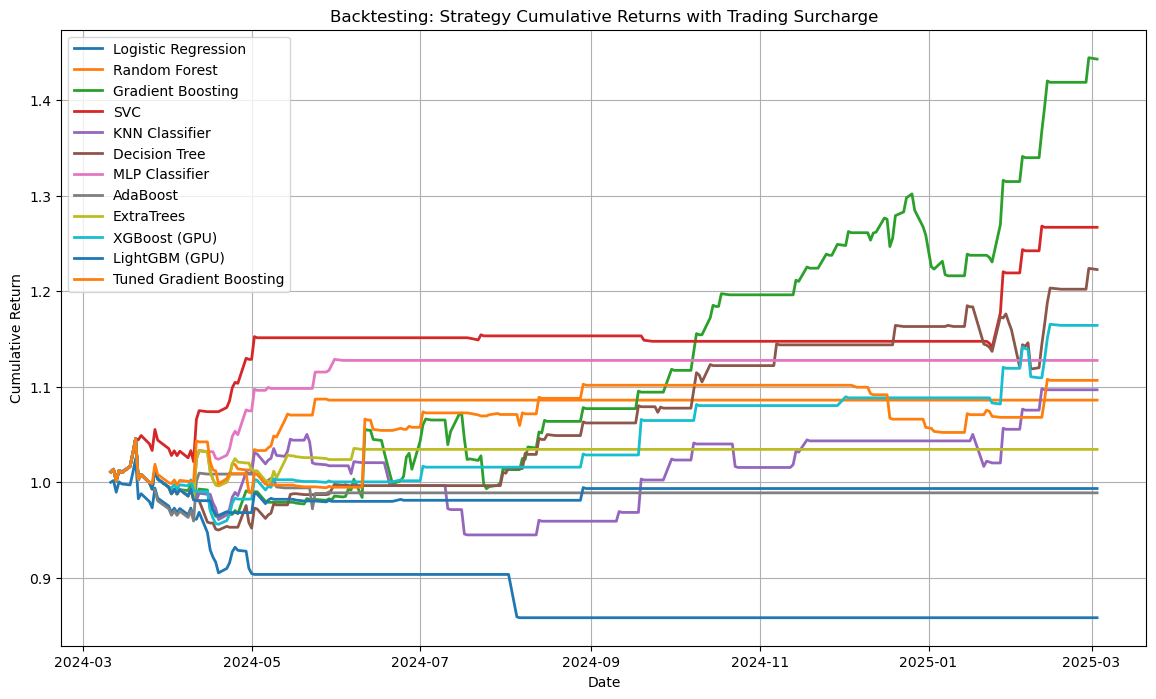

In [33]:
# ---------------------------
# Plot All Models' Cumulative Returns on a Single Graph
# ---------------------------
plt.figure(figsize=(14, 8))
colors = plt.cm.tab10.colors  # a palette with at least 10 colors
for idx, (name, cum_return) in enumerate(cumulative_returns.items()):
    plt.plot(cum_return.index, cum_return, label=name, color=colors[idx % len(colors)], linewidth=2)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Backtesting: Strategy Cumulative Returns with Trading Surcharge")
plt.legend()
plt.grid(True)
plt.show()

---- Logistic Regression ----
Accuracy: 0.39591836734693875
Confusion Matrix:
 [[ 82  19]
 [129  15]]
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.81      0.53       101
           1       0.44      0.10      0.17       144

    accuracy                           0.40       245
   macro avg       0.41      0.46      0.35       245
weighted avg       0.42      0.40      0.32       245

---- Random Forest ----
Accuracy: 0.44081632653061226
Confusion Matrix:
 [[ 85  16]
 [121  23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.84      0.55       101
           1       0.59      0.16      0.25       144

    accuracy                           0.44       245
   macro avg       0.50      0.50      0.40       245
weighted avg       0.52      0.44      0.38       245

---- Gradient Boosting ----
Accuracy: 0.5061224489795918
Confusion Matrix:
 [[56 45]
 [76 68]]
Class

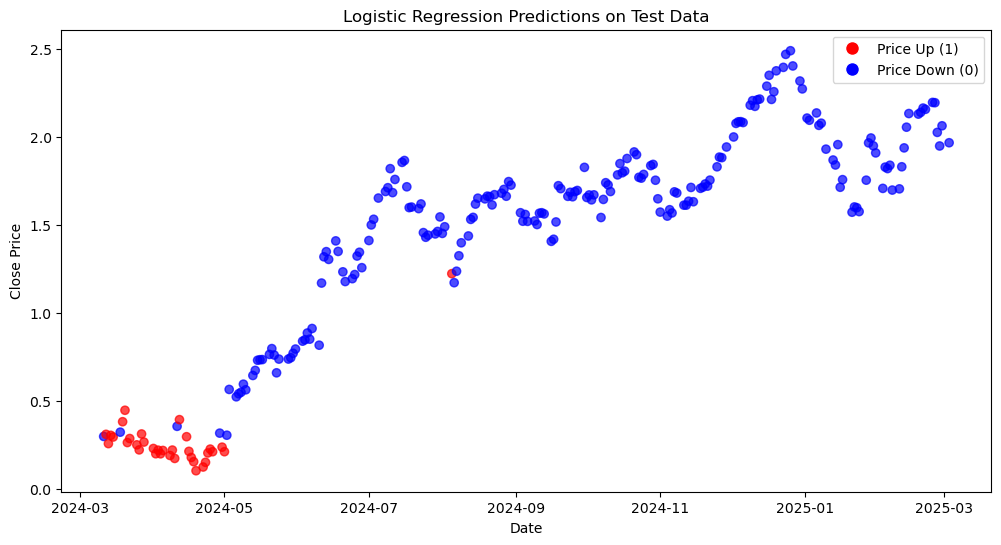

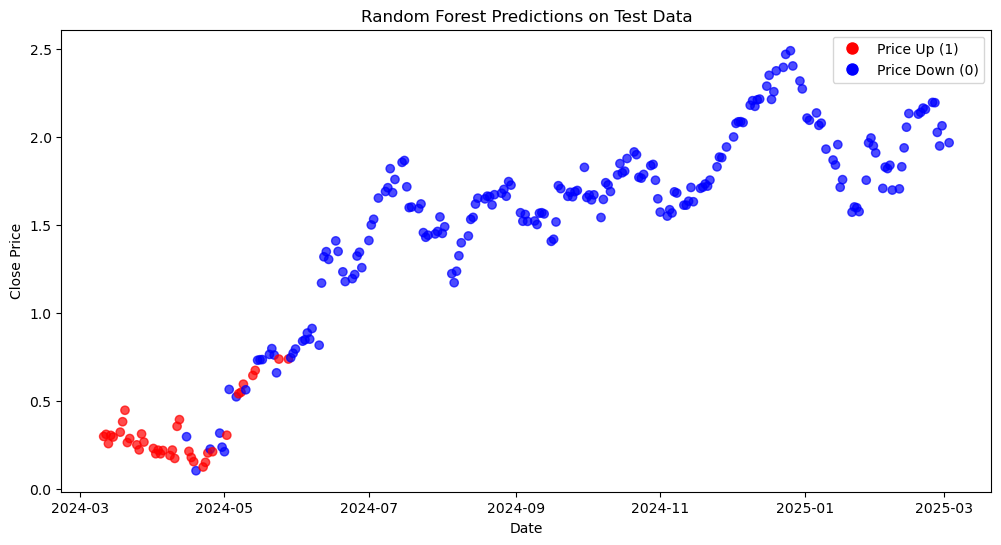

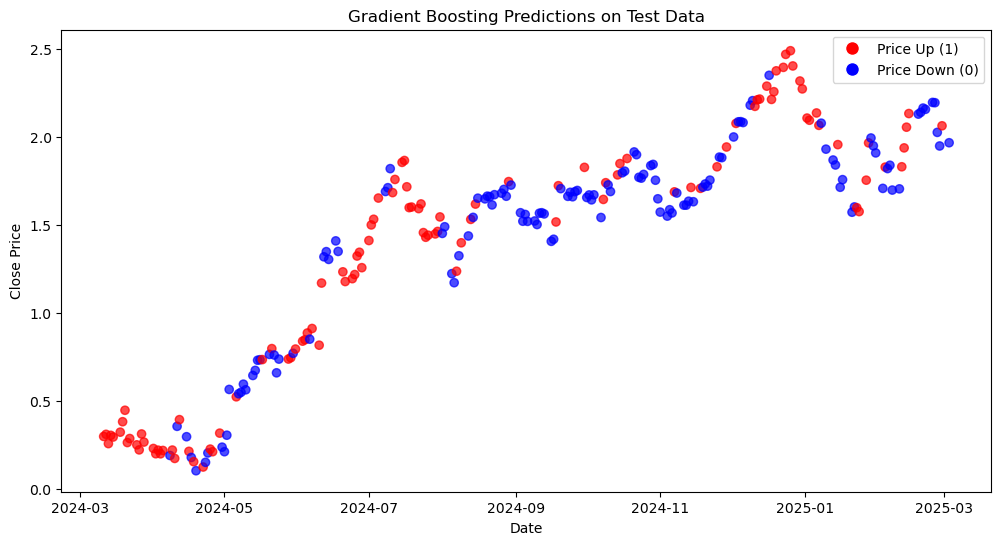

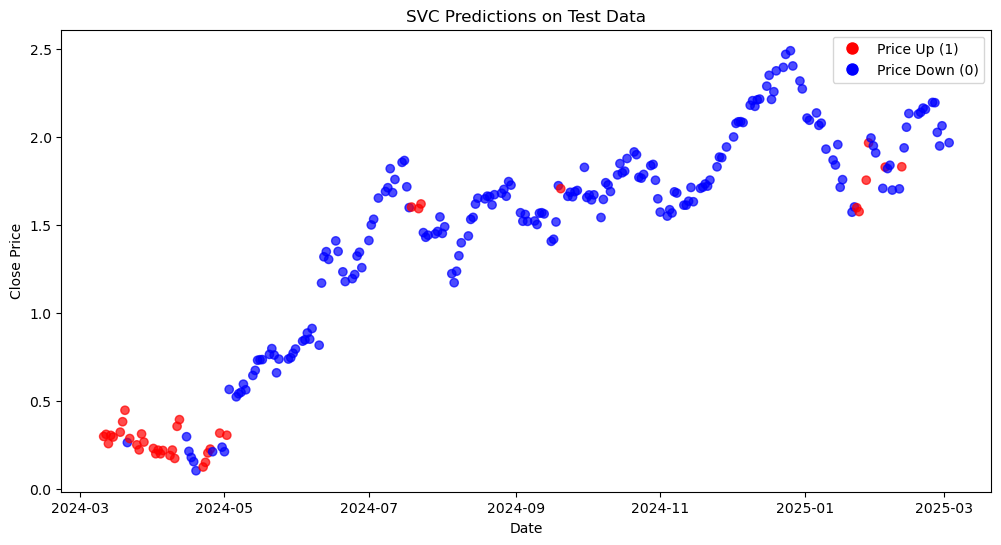

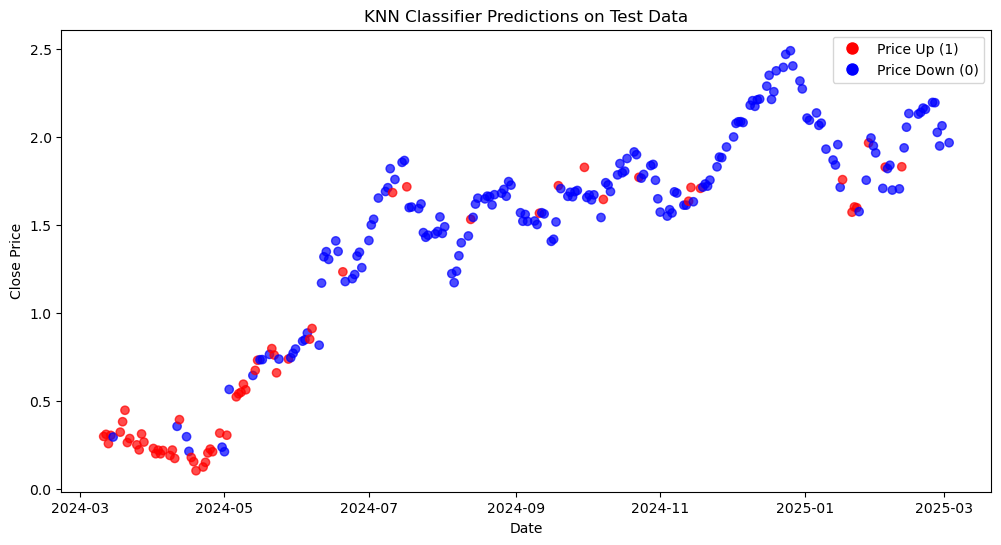

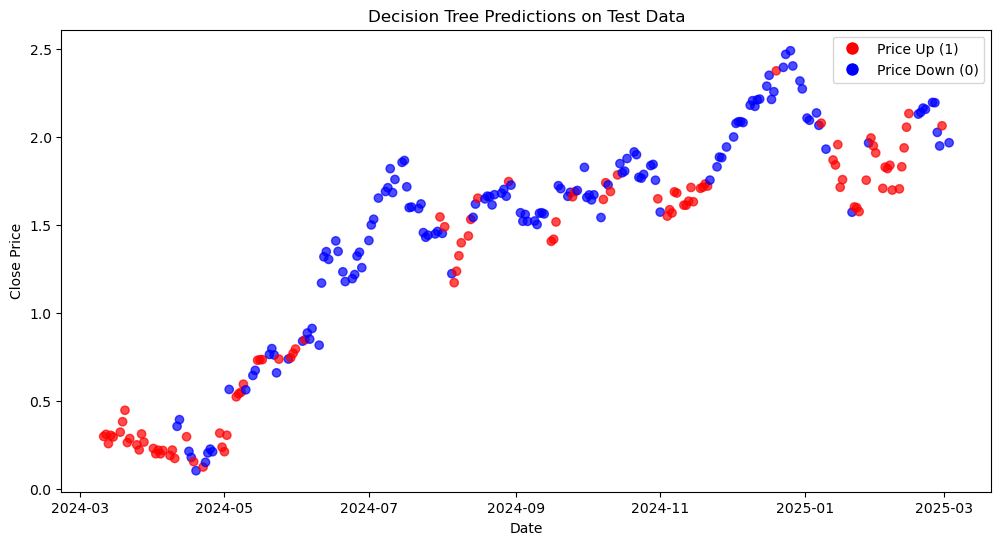

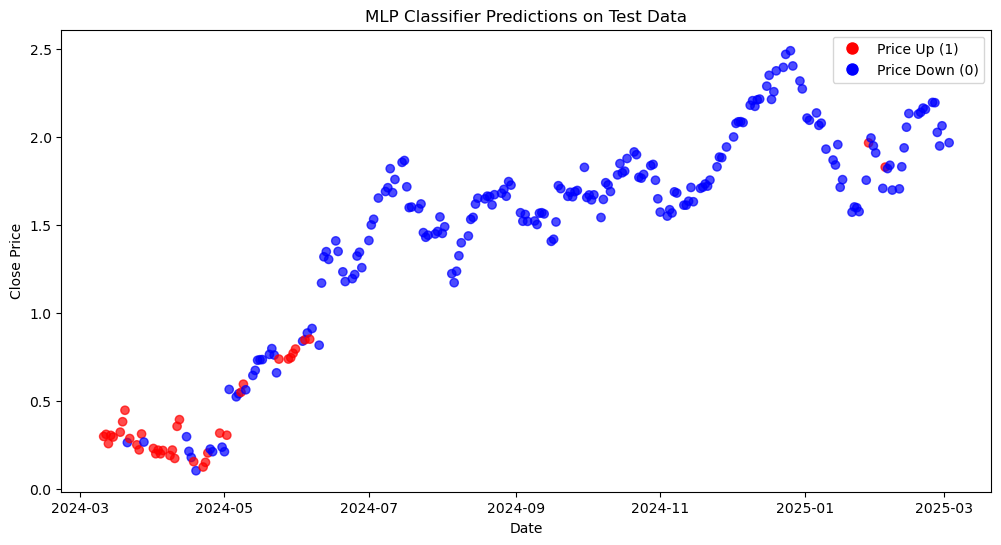

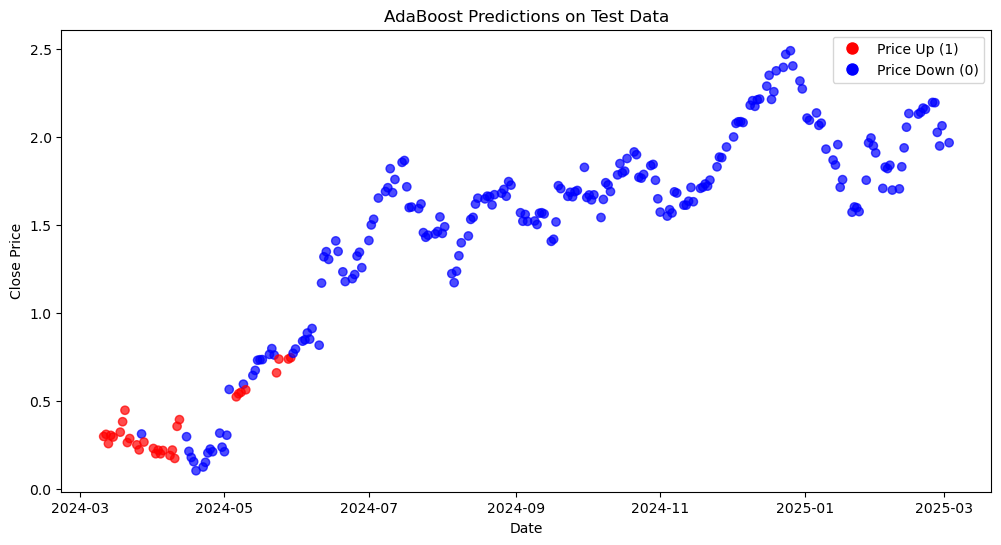

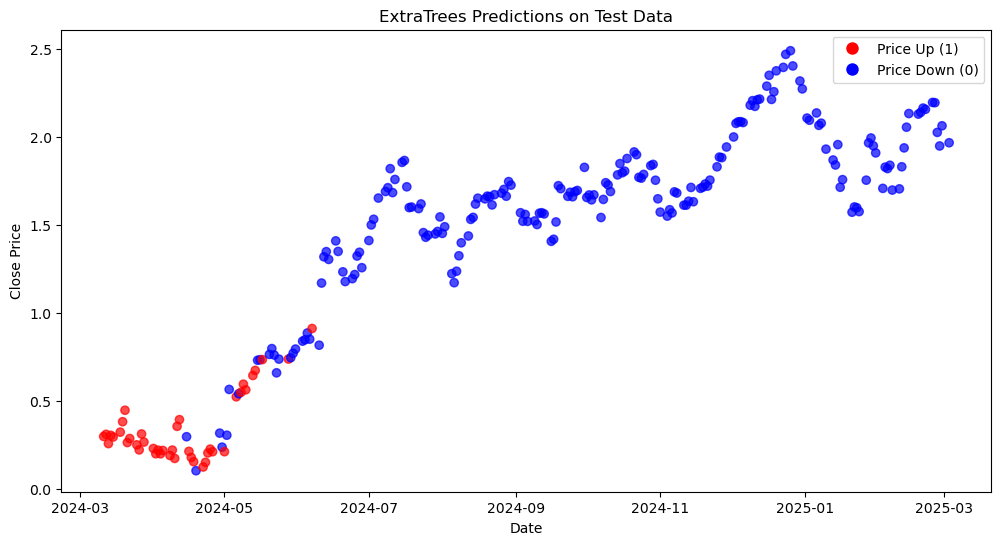

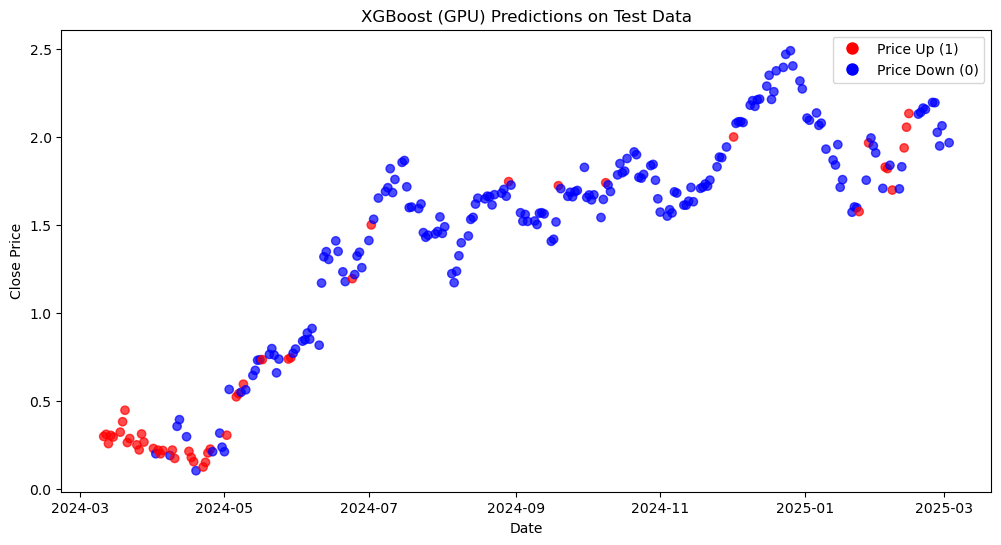

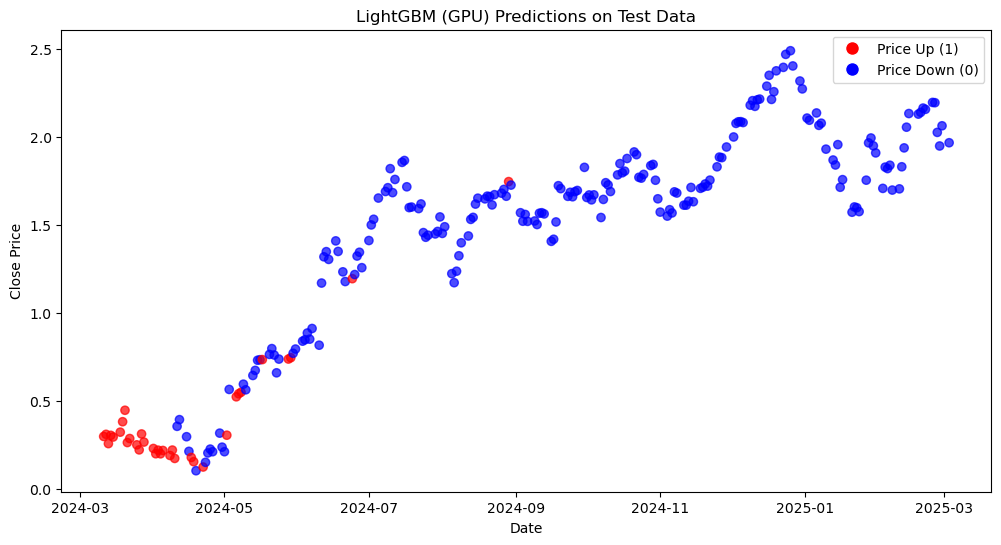

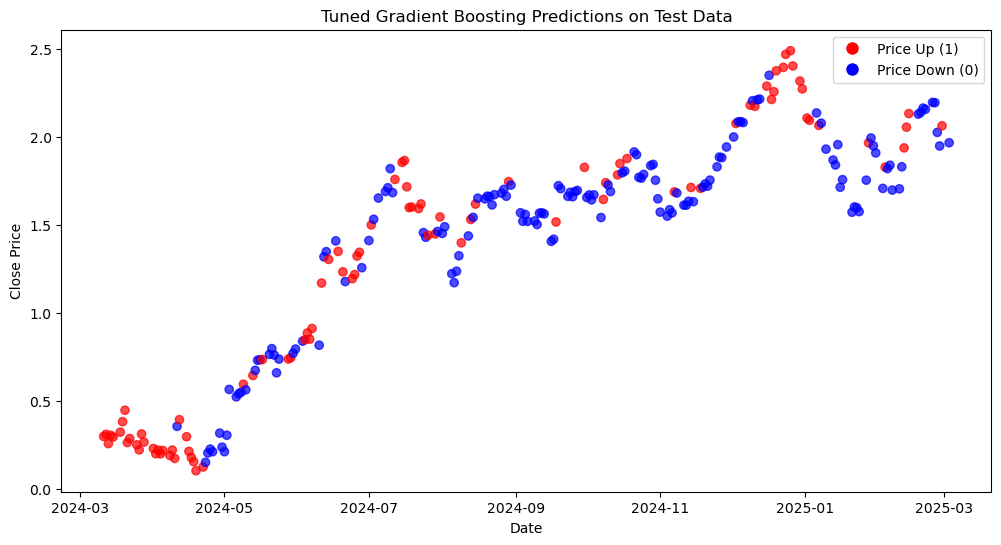

In [36]:
from matplotlib.lines import Line2D

# ---------------------------
# Fit, Predict, and Plot for Each Model
# ---------------------------
for name, model in models.items():
    print(f"---- {name} ----")
    # Fit the classifier on the training set
    model.fit(X_train, y_train)
    # Predict the test set
    y_pred = model.predict(X_test)
    # Calculate accuracy and print performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Create a color list: red if prediction==1 (up), blue if prediction==0 (down)
    colors = ['red' if pred == 1 else 'blue' for pred in y_pred]
    
    # Plot the test data's Close price, coloring each point based on the prediction.
    plt.figure(figsize=(12, 6))
    plt.scatter(X_test.index, X_test['Close'], c=colors, alpha=0.7)
    plt.title(f"{name} Predictions on Test Data")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    
    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Price Up (1)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Price Down (0)', markerfacecolor='blue', markersize=10)
    ]
    plt.legend(handles=legend_elements)
    
    # plt.show()

---- Logistic Regression on Training Data ----
Accuracy: 0.548618219037871
Confusion Matrix:
 [[201 266]
 [175 335]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.43      0.48       467
           1       0.56      0.66      0.60       510

    accuracy                           0.55       977
   macro avg       0.55      0.54      0.54       977
weighted avg       0.55      0.55      0.54       977

---- Random Forest on Training Data ----
Accuracy: 1.0
Confusion Matrix:
 [[467   0]
 [  0 510]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       467
           1       1.00      1.00      1.00       510

    accuracy                           1.00       977
   macro avg       1.00      1.00      1.00       977
weighted avg       1.00      1.00      1.00       977

---- Gradient Boosting on Training Data ----
Accuracy: 0.8536335721596725
Confusion 

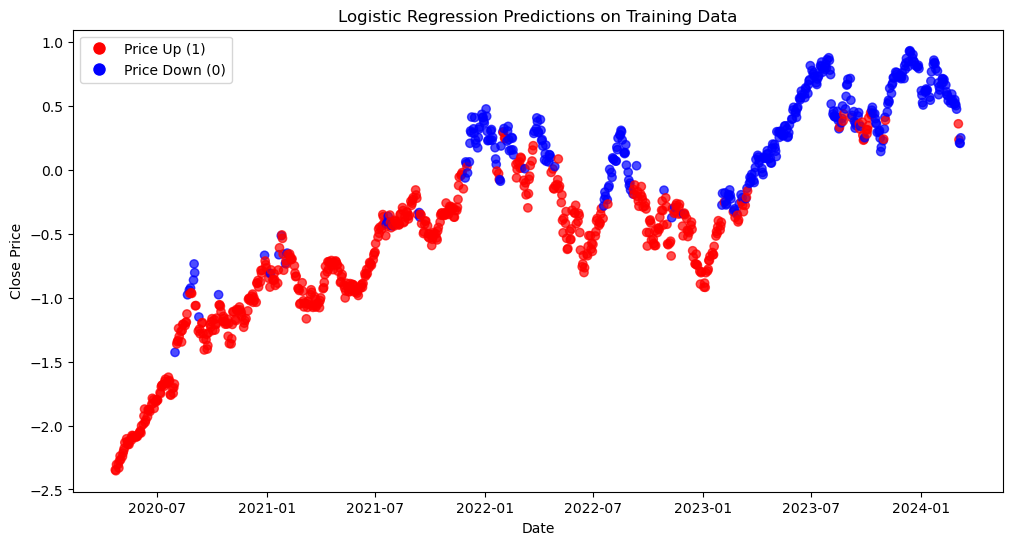

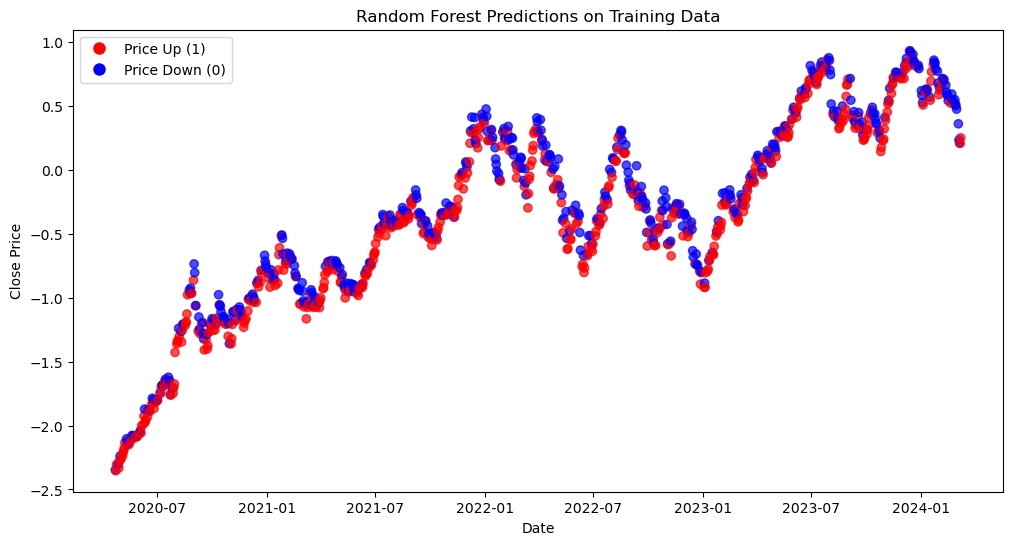

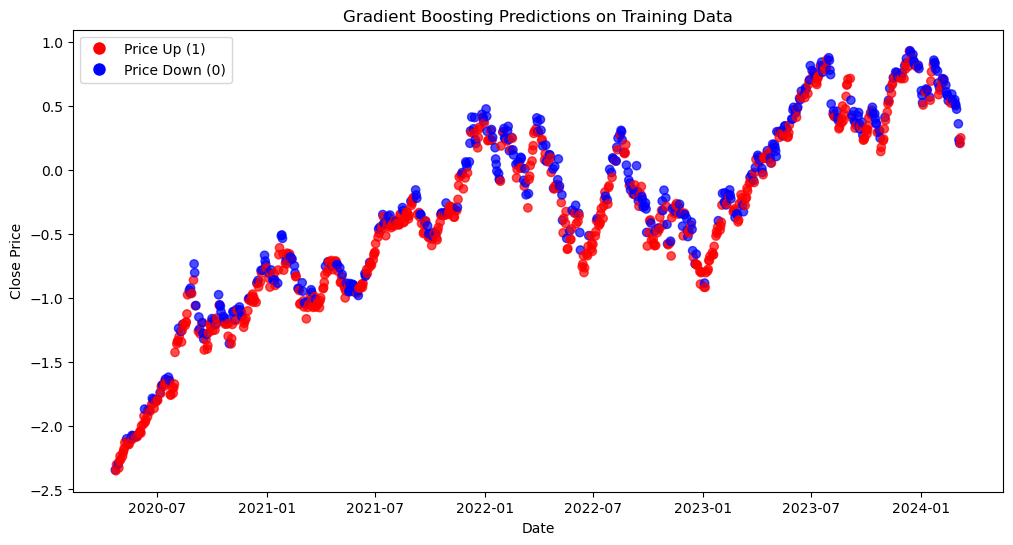

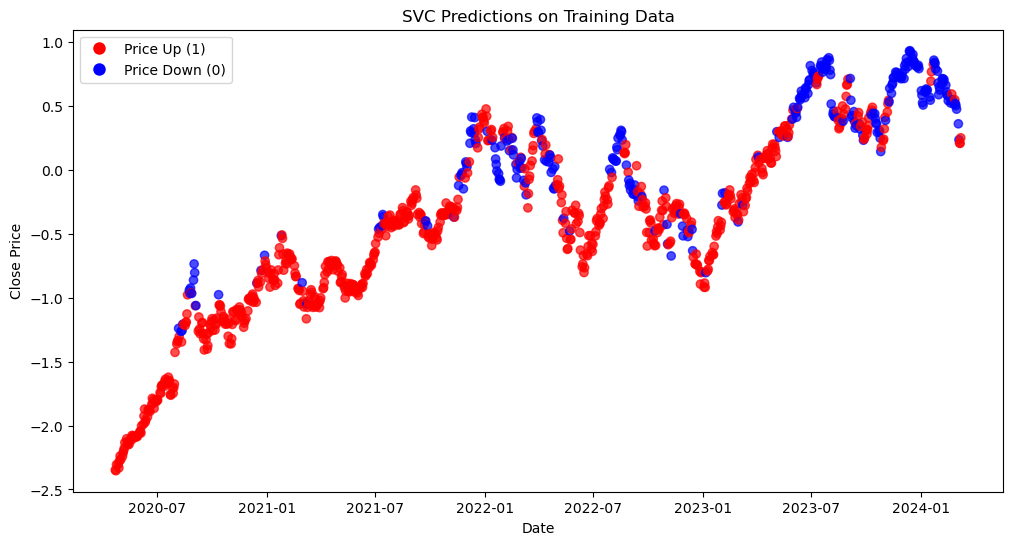

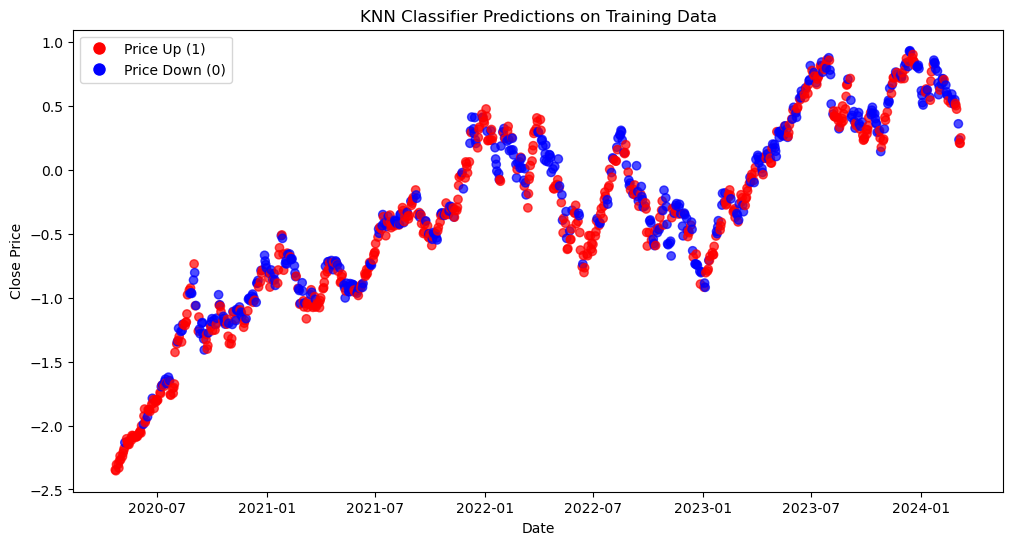

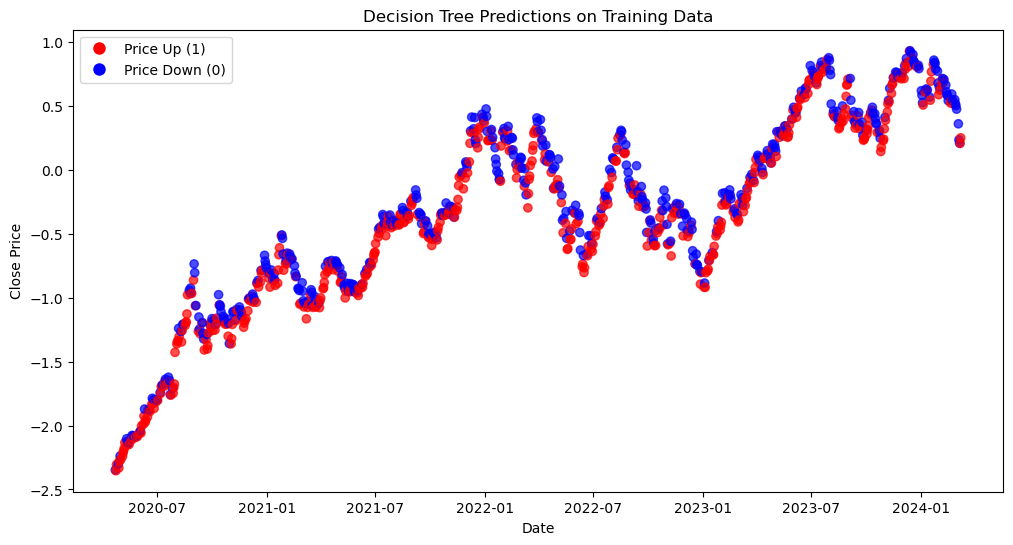

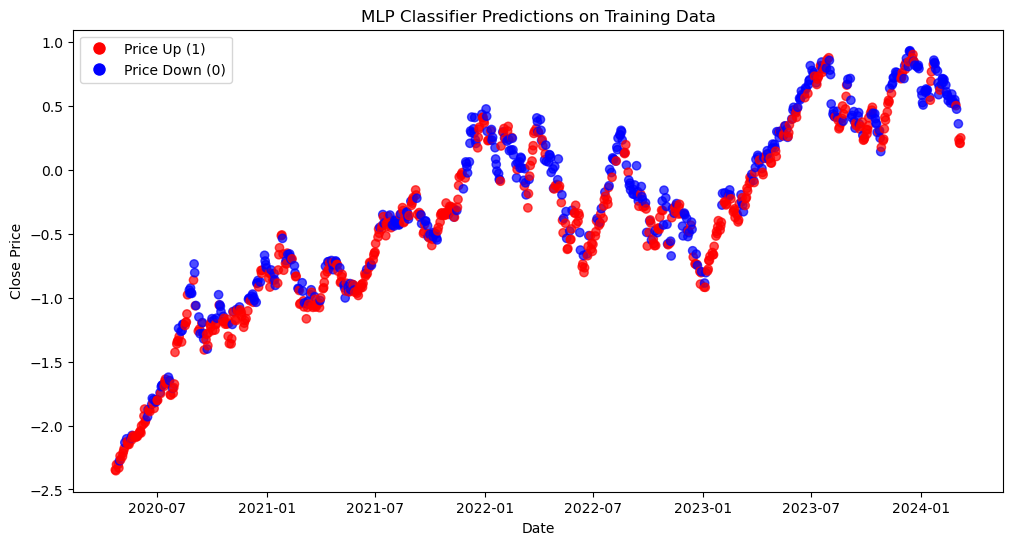

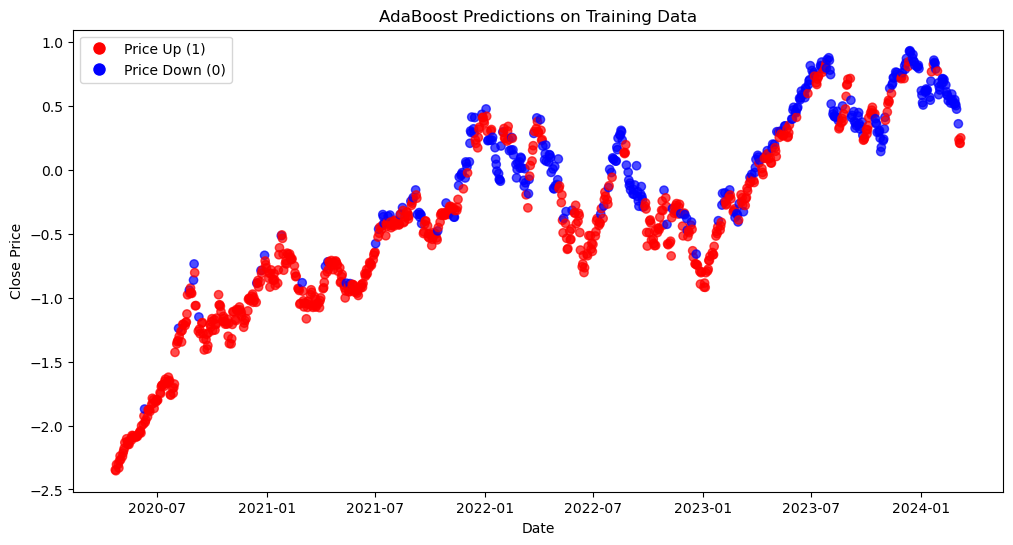

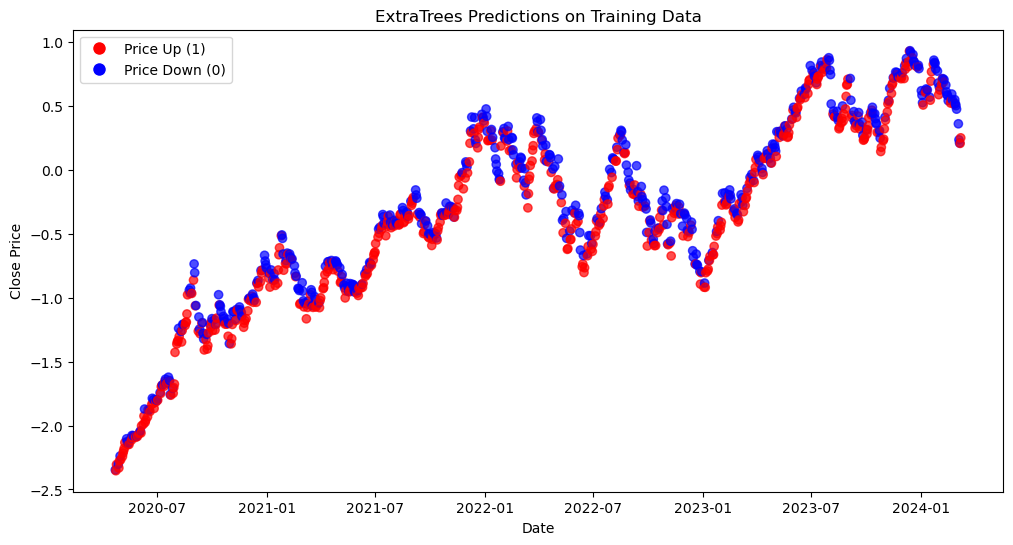

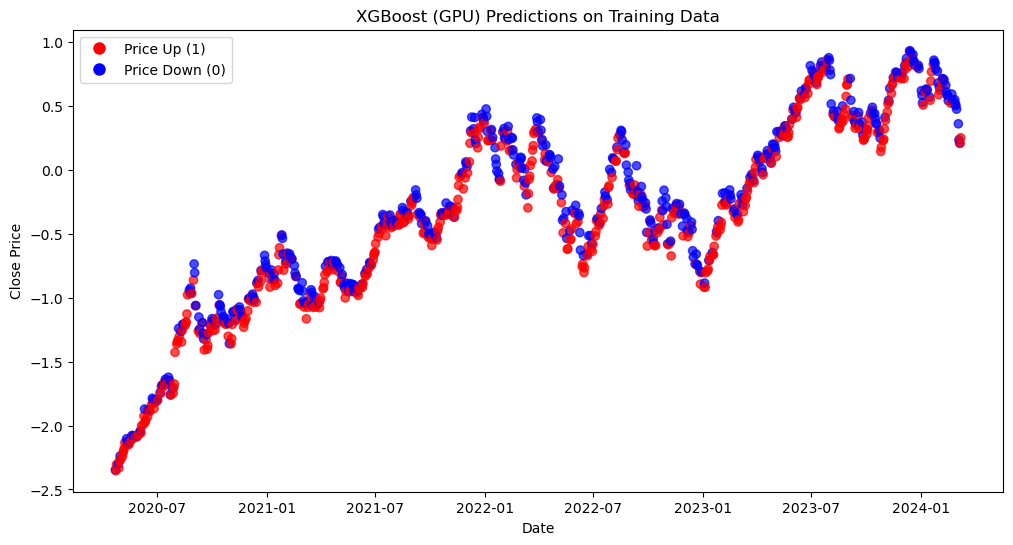

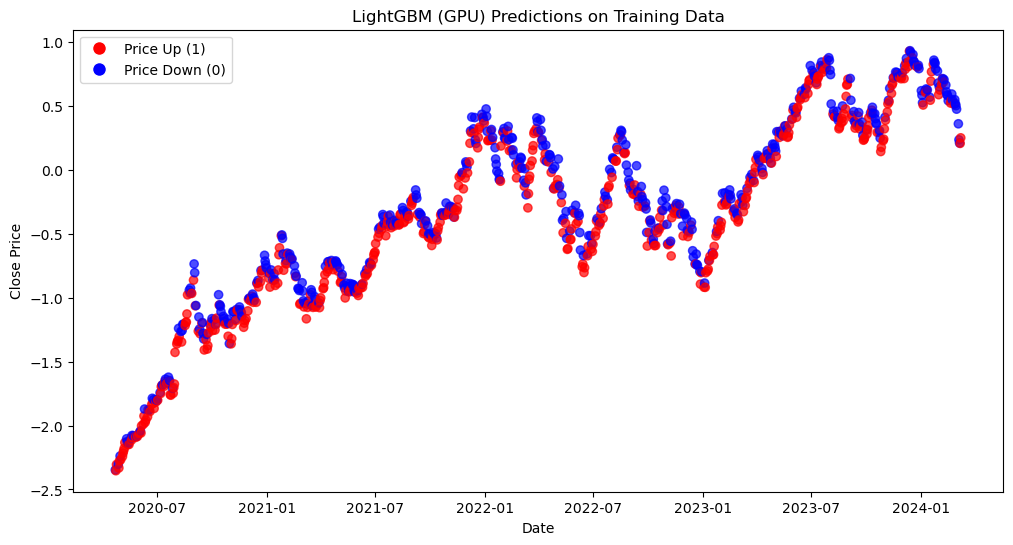

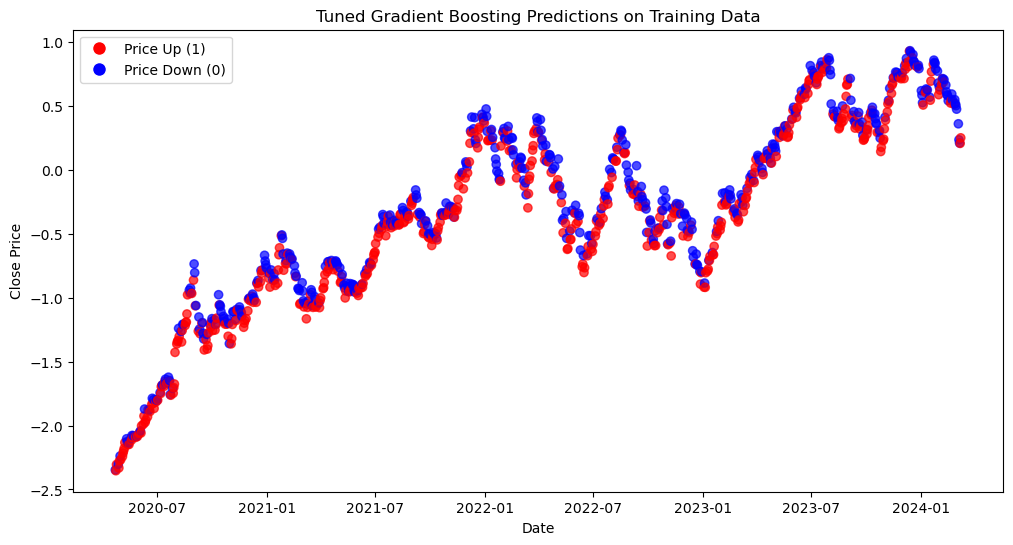

In [35]:
# ---------------------------
# Plot Predictions on Training Data for Each Model
# ---------------------------
for name, model in models.items():
    print(f"---- {name} on Training Data ----")
    # Fit the model on training data
    model.fit(X_train, y_train)
    # Predict on training data
    y_train_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_train_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
    print("Classification Report:\n", classification_report(y_train, y_train_pred))
    # Create color mapping: red if predicted 1 (up), blue if predicted 0 (down)
    colors_train = ['red' if pred == 1 else 'blue' for pred in y_train_pred]
    
    # Create scatter plot for training data
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train.index, X_train['Close'], c=colors_train, alpha=0.7)
    plt.title(f"{name} Predictions on Training Data")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    
    # Create a custom legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Price Up (1)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Price Down (0)', markerfacecolor='blue', markersize=10)
    ]
    plt.legend(handles=legend_elements)
    # plt.show()